# 3.3 Reanalysis Data

In the previous section of this chapter we explored a gridded observational data product. Gridded observations can be very useful, but as we saw, they can suffer from limitations. These include a limited spatial extent - we don't always have observations for every location (especially in the Southern Hemisphere, where observational data is more limited). Another case that has not yet been discussed is when observations are not available for a variable you need for your analysis. For example, the NRCAN ANUSPLIN gridded observations include precipitation, daily maximum, and daily minimum temperature. What if your analysis requires relative humidity, or wind speed? Or what if you need data at sub-daily temporal intervals, such as hourly or 6-hourly? When observational data is not available, the next best thing to use is often **reanalysis** data. 

Reanalysis is produced by constraining a numerical weather forecast model with observational data from many sources, through a process called data assimilation. One can think of it as similar to a forecast, but with the advantage of being informed by observations both before, during, and after the time of interest. Because reanalysis is produced by a model, it has global coverage and can provide data for variables and locations for which we don't have observations. These estimates are still constrained by observations, through covariances that arise from physical relationships. 

However, one must still be careful when using reanalysis data, as there can be biases that arise through systematic model errors, or due to a lack of constraint in regions that are especially sparse of observations. Before using reanalysis data, it's best to validate it against any observations available in your study region, to characterize these biases and ensure that reanalysis is appropriate for your study.

The current state-of-the-art global reanalysis is the 5th version of the reanalysis produced by the European Centre for Medium-Range Weather Forecasts ([ERA5](https://confluence.ecmwf.int/display/CKB/ERA5)) {cite}`hersbach_era5_2020`. The spatial resolution of ERA5 is 0.25$^{\circ}$ latitude $\times$ longitude and data is available at hourly intervals  so the volume of data can be very large. When sub-daily data is needed, it is common to use 6-hourly intervals to reduce the computational demands of the analysis.

## 3.3.1 Accessing the Data

A limited selection of ERA5 variables at both hourly and daily frequencies with spatial coverage over North America is hosted on the PAVICS server. If you require other variables or data for a different part of the world, you can download it to a netCDF file via the [Copernicus Climate Data Store](https://doi.org/10.24381/cds.adbb2d47) using their [Python API](https://cds.climate.copernicus.eu/api-how-to). The CDS API supports both spatial and temporal subsetting in a download request, so you can download only the data you need - though this is still likely to be many GB if you require hourly data, even for a moderately sized spatial domain.

In this notebook, we will acquire ERA5 daily maximum temperature data from the PAVICS OPeNDAP server, select a region for analysis, and validate the reanalysis against station observations in the region of study. As with the previous notebook, we will use `xarray` as the primary tool for analysis.

In [1]:
import numpy as np
import xarray as xr
import dask
import scipy.stats as stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
import pandas as pd
import ec3    

In [2]:
def download_station_data(stn_id, years = range(1992, 2022), var = 'MaxTemp'):
    """
    Download ECCC observational data at the weather station identified with stn_id,
    re-name the columns to more useful names. Optional: select specific years of data,
    but by default, download all data from 1990--2020.
    """
    # download the data
    df = ec3.get_data(stn_id, years = years, progress = False)
    
    # dictionary mapping original column names to new ones
    column_name_dict = {'Date/Time': 'Date', 
                        'Max Temp (°C)': 'MaxTemp', 
                        'Min Temp (°C)': 'MinTemp',
                        'Mean Temp (°C)': 'MeanTemp',
                        'Total Precip (mm)': 'TotalPrecip',
                        'Latitude (y)': 'lat',
                        'Longitude (x)': 'lon',
                        'Station Name': 'Name'}
    
    df = df.rename(columns = column_name_dict)
    
    # select only a single variable, given by the arg 'var' (plus the important identifying info)
    if var != 'all':
        df = df[[var, 'Date', 'lat', 'lon', 'Name']]
    else: # keep all the ones we re-names
        df = df[list(column_name_dict.keys())]
    
    # set the "Date" column as an index column and convert it from strings to Datetime objects to make
    # selecting times easier
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index("Date")
    
    # sort the data in proper chronological order
    df = df.sort_index()
    
    return df

In [3]:
# PAVICS URL for ERA5 data
url_pavics_era5 = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/reanalyses/catalog.xml"
cat = TDSCatalog(url_pavics_era5)
for dataset in cat.datasets:
    print(dataset)

day_RDRSv2.1_NAM.ncml
day_ERA5_NAM.ncml
day_ERA5-Land_NAM.ncml
1hr_RDRSv2.1_NAM.ncml
1hr_ERA5_NAM.ncml
1hr_ERA5-Land_NAM.ncml


The PAVICS reanalysis catalog contains 4 datasets. Two are for daily frequency, two for hourly frequency. The ones with ERA5-Land in their name are for a reanalysis product related to ERA5, [which you can read more about here](https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation). 


## 3.3.2 Validating Reanalysis Against Station Observations

Since we will be analyzing daily maximum temperature, we will load data from the first dataset, `day_ERA5_NAM.ncml`. The region we will select for validation is the greater Vancouver area.

In [4]:
# access the ERA5 data through the OPenDAP server
ix = list(cat.datasets).index("day_ERA5_NAM.ncml")
era5_ds = xr.open_dataset(cat.datasets[ix].access_urls["OPENDAP"])

# lat and lon for Vancouver
lat_vcr = 49.28
lon_vcr = -123.12

# size of domain
dlat = 2.5
dlon = 2.5

# extract tasmax data for the selected region - 5x5 degrees centred at Vancouver
tasmax_era5 = era5_ds.tasmax.sel(lat = slice(lat_vcr - dlat, lat_vcr + dlat),
                                 lon = slice(lon_vcr - dlon, lon_vcr + dlon))

# select 30-year period for climatology 
yrmin = 1992
yrmax = 2021
year_range = range(yrmin, yrmax + 1)
tasmax_era5 = tasmax_era5.sel(time = tasmax_era5.time.dt.year.isin(year_range))

# chunk for automatic parallelization with dask
tasmax_era5 = tasmax_era5.chunk('auto')

# convert from Kelvin to Celsius to match the observations
tasmax_era5 = tasmax_era5 - 273.15


In [5]:
# find station data in Vancouver
find_stn_results = ec3.find_station(target = (lat_vcr, lon_vcr), 
                                    period = year_range,
                                    type = 'daily',
                                    # each 0.25 degree grid cell is about 30 km
                                    dist = range(int(30 * dlat / 0.25)))

/Users/mikemorris/opt/anaconda3/envs/UTCDW-env/lib/python3.10/site-packages/ec3.py:105: UserWarning: Cannot find the station inventory in the current working directory.
  warnings.warn("Cannot find the station inventory in the current working directory.")


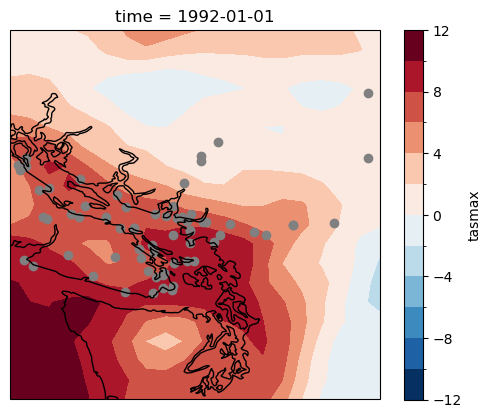

In [6]:
# plot the locations of each of the stations
lats = find_stn_results['Latitude (Decimal Degrees)']
lons = find_stn_results['Longitude (Decimal Degrees)']

# select stations only within our ERA5 domain
is_in_domain = (lons >= tasmax_era5.lon.min()) & ((lons <= tasmax_era5.lon.max())) & \
               (lats >= tasmax_era5.lat.min()) & ((lats <= tasmax_era5.lat.max()))

lons = lons[is_in_domain]
lats = lats[is_in_domain]

# plot on top of a temperature sample for a particular time
fig, ax = plt.subplots(subplot_kw = dict(projection = ccrs.PlateCarree(), transform = ccrs.PlateCarree()))
tasmax_era5.isel(time = 0).plot.contourf(ax = ax, levels = 15)
ax.scatter(lons, lats, marker = 'o', color = 'gray')
ax.coastlines()
plt.show()

This is a lot of stations! Since the UTCDW Guidebook is for instructional purposes, we will look at data for only 5 of them. For scientific purposes, the best practice is to include all available data in your analysis.

In [7]:
# filter the station results so we only keep stations that are inside our domain
stn_ids = find_stn_results['Station ID'][is_in_domain]

# select the first 5
stn_ids = stn_ids[0:10][::2]

# download the station data for each station in the domain
stn_df_dict = {}
for stn_id in stn_ids:
    stn_df = download_station_data(stn_id, years = year_range, var = 'MaxTemp')
    name = stn_df['Name'][0]
    print(name, stn_df.dropna().index.min(), stn_df.dropna().index.max())
    stn_df_dict[name] = stn_df

VANCOUVER HARBOUR CS 1992-01-01 00:00:00 2021-12-31 00:00:00
WEST VANCOUVER AUT 1992-12-01 00:00:00 2021-12-31 00:00:00
N VANC GROUSE MTN RESORT 1992-01-01 00:00:00 2021-12-31 00:00:00
RICHMOND NATURE PARK 1992-01-01 00:00:00 2021-12-31 00:00:00
PORT MOODY GLENAYRE 1992-01-01 00:00:00 2021-12-31 00:00:00


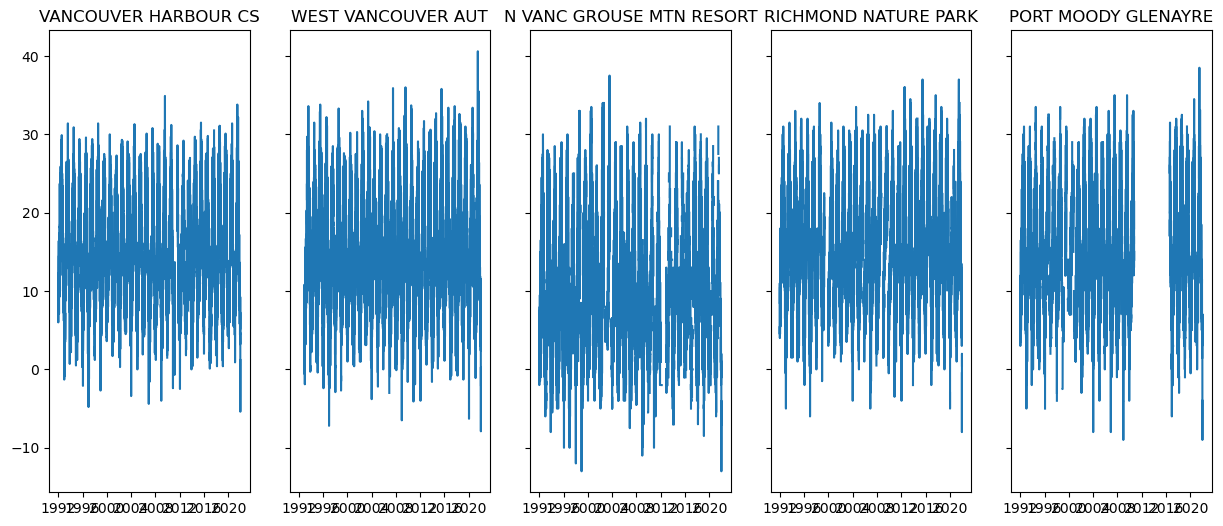

In [8]:
# plot time series for each station to check if there is missing data
fig, axes = plt.subplots(ncols = 5, figsize = (15, 6), sharex = True, sharey = True)
for i, name in enumerate(stn_df_dict.keys()):
    axes[i].set_title(name)
    stn_df = stn_df_dict[name]
    axes[i].plot(stn_df.index, stn_df.MaxTemp)
plt.show()

The station `PORT MOODY GLENAYRE` has a long period of missing data, and some of the other stations appear to be missing data for certain periods as well. For a fair comparison, it's important to mask the reanalysis when the obs are missing data (after checking that there wasn't a station ID change during that period, though we won't do that here - see Section 3.1). Luckily, `xarray` has built-in capability of handling missing values, and usually neglects them in calculations.

Next we will convert the station data from `pandas.DataFrame`s into `xarray.DataArray`s, and begin the comparison of the reanalysis and observations.

In [9]:
ds_list = []
for name in stn_df_dict.keys():
    df = stn_df_dict[name]
    # convert to xarray
    ds = xr.Dataset.from_dataframe(df[['MaxTemp']])
    lats = df.lat.values[0]
    lons = df.lon.values[0]
    ds = ds.assign(lat = lats, lon = lons)
    ds['stn'] = name
    ds = ds.set_coords('stn')
    ds = ds.rename({'Date': 'time'})
    ds_list.append(ds)

stn_ds = xr.concat(ds_list, dim = 'stn')

In [11]:
# calculate some metrics for agreement between ERA5 and the station

# first linearly interpolate the ERA5 data to the station locations
tasmax_era5_stns = tasmax_era5.interp(lat = stn_ds.lat, lon = stn_ds.lon)

# next calculate correlations over time
correlations = xr.corr(stn_ds.MaxTemp, tasmax_era5_stns, dim = 'time')

# print them out along with each station's name
for name in stn_ds.stn:
    print(name.values, correlations.sel(stn = name).values)

VANCOUVER HARBOUR CS 0.96688561972108
WEST VANCOUVER AUT 0.9584361968597485
N VANC GROUSE MTN RESORT 0.9179077908410244
RICHMOND NATURE PARK 0.9577980145350571
PORT MOODY GLENAYRE 0.95990908965584


For each of the stations we investigated, the ERA5 daily maximum temperatures are highly correlated with the observations. This tells us the day-to-day fluctuations are very similar, but what about the magnitude of the temperature? Next let's calculate the mean bias and root mean squared error (RMSE) to investiagte.

In [12]:
errors = tasmax_era5_stns - stn_ds.MaxTemp
mean_biases = errors.mean('time')
rms_errors = np.sqrt(np.square(errors).mean('time'))

for name in stn_ds.stn:
    print("===============", name.values, "===============")
    # the %.2f means print the floating point decimal to 2 decimal places
    print('Mean Bias: %.2f degC' % mean_biases.sel(stn = name).values)
    print('RMSE: %.2f degC' % rms_errors.sel(stn = name).values)

=============== VANCOUVER HARBOUR CS ===============
Mean Bias: -1.84 degC


Error:DAP DATADDS packet is apparently too short


RMSE: 2.50 degC
=============== WEST VANCOUVER AUT ===============
Mean Bias: -2.34 degC
RMSE: 3.10 degC
=============== N VANC GROUSE MTN RESORT ===============
Mean Bias: 2.94 degC
RMSE: 4.31 degC
=============== RICHMOND NATURE PARK ===============
Mean Bias: -2.01 degC


Error:DAP DATADDS packet is apparently too short


RMSE: 2.91 degC
=============== PORT MOODY GLENAYRE ===============
Mean Bias: -0.57 degC
RMSE: 2.16 degC


The biases here are not terribly large, but are substantial enough to be worth taking into account if ERA5 were to be used as the reference data set for a downscaling study. Of course for Vancouver, we could just use a gridded observational product directly if spatial information is needed. This brief analysis demonstrates that even for regions with plenty of observational data, reanalysis data must still be used with caution. While it is a very useful tool for climate analysis, it is not a perfect substitute for observational data.

## Appendix: Other reanalyses & analysis data

To quantify uncertainty in reanalysis data, it can be useful to compare results across multiple data products. Other current-generation reanalysis include [MERRA2](https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/) produced by NASA in the United States, and [JRA-55](https://climatedataguide.ucar.edu/climate-data/jra-55) produced by the Japanese Meterological Agency.

For some applications, data with a higher spatial resolution than the 0.25$^{\circ}$ of ERA5 is required. The ECMWF also publishes a [9 km resolution operational analysis](https://rda.ucar.edu/datasets/ds113.1/). Operational analysis which is similar to a reanalysis, but does not include observations after the fact since it is produced in near real-time (it is used as initial conditions for weather forecasts). This product only includes data back to 2016, when the ECMWF started producing forecasts at this resolution. Unfortunately, it is not very useful as training data for downscaling, because its limited record means it cannot be used to robustly characterize long-term climate statistics.

ECCC also produces operational analysis and weather forecasts at high resolution, up to 2.5 km. These data products also suffer from a limited record length, but if they are of interest, they can be accessed via the [Canadian Surface Prediction Archive](https://caspar-data.ca/).